In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import backend as K

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

In [ ]:
import tensorflow as tf

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/data/Reviews.csv", nrows=100000)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
#drop the duplicate and na values from the records
df.drop_duplicates(subset=['Text'],inplace=True)

In [ ]:
df.dropna(axis=0,inplace=True)

In [ ]:
input_data = df.loc[:,'Text']
target_data = df.loc[:,'Summary']

In [ ]:
input_data.head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

In [ ]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]

In [ ]:
contractions=pickle.load(open("/content/drive/MyDrive/text-summarization-ml-project/contractions.pkl","rb"))['contractions']


In [ ]:
#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

In [ ]:
def clean(texts,src):
  #remove the html tags
  texts = BeautifulSoup(texts, "lxml").text
  #tokenize the text into words 
  words=word_tokenize(texts.lower())
  #filter words which contains \ 
  #integers or their length is less than or equal to 3
  words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
  #contraction file to expand shortened words
  words= [contractions[w] if w in contractions else w for w in words ]
  #stem the words to their root word and filter stop words
  if src=="inputs":
    words= [stemm.stem(w) for w in words if w not in stop_words]
  else:
    words= [w for w in words if w not in stop_words]
  return words

In [ ]:
#pass the input records and taret records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add 'sos' at start and 'eos' at end of text
  tr_words= clean("sos "+tr_txt+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words


In [ ]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words

#get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])

In [ ]:
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)


number of input words :  32198
number of target words :  14170
maximum input length :  74
maximum target length :  17


In [ ]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0)


In [ ]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)

In [ ]:
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train) 

In [ ]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')


In [ ]:

#decoder input data will not include the last word 
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

In [ ]:
K.clear_session() 
latent_dim = 500


In [ ]:
#create input object of total number of input words
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs) 


In [ ]:
#create 3 stacked LSTM layer with the shape of hidden dimension
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 

#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 

#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)

In [ ]:

#encoder states
en_states= [state_h3, state_c3]

# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 

In [ ]:
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 


In [ ]:

#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])

In [ ]:
#Concatenate the attention output with the decoder ouputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [ ]:
#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax') 
dec_outputs = dec_dense(merge) 


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 500)      16099500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 74, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

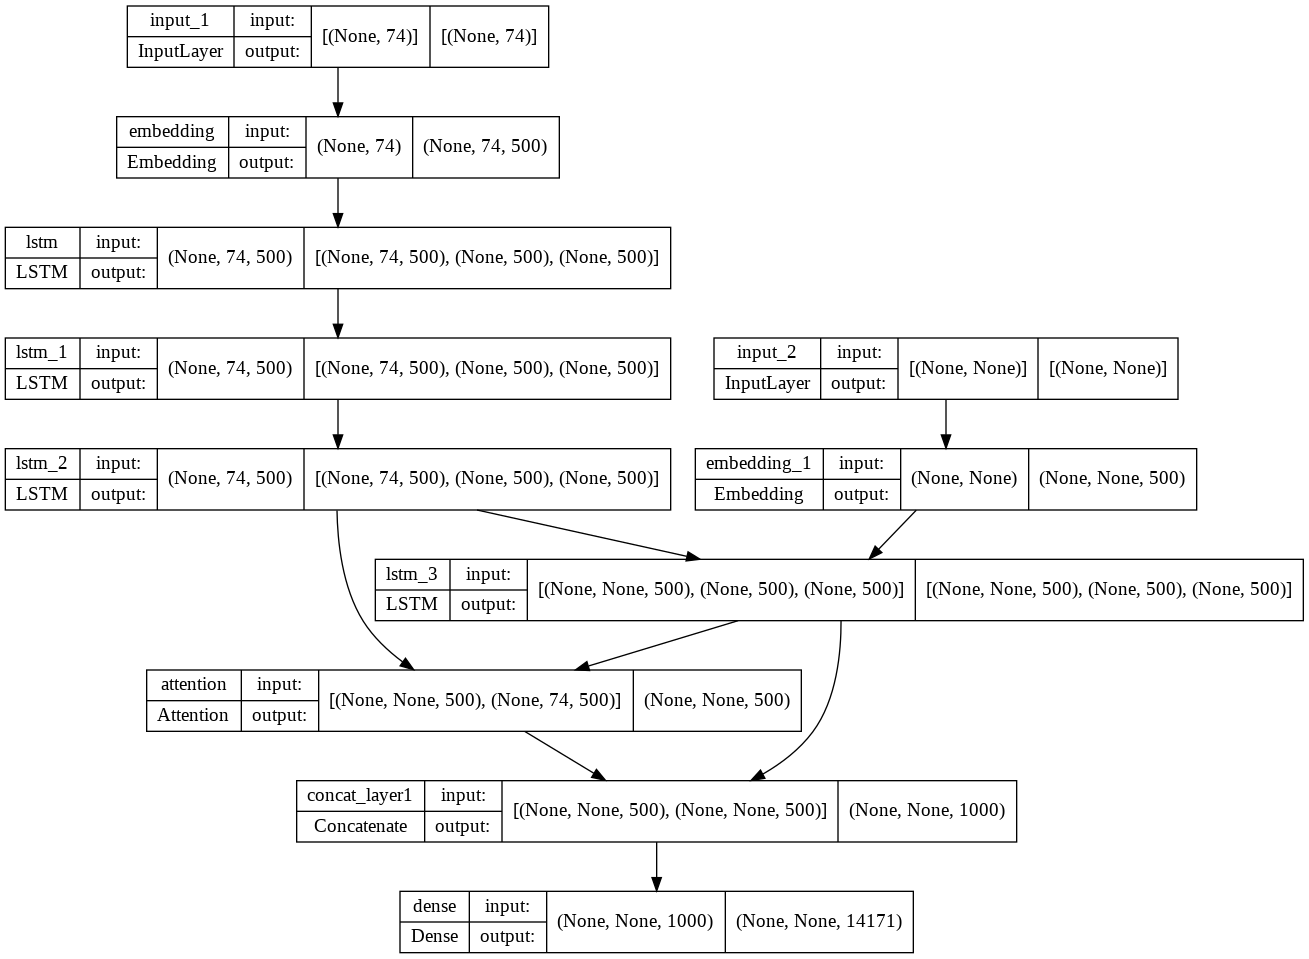

In [ ]:

#Mode class and model summary
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile( 
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 
model.fit( 
    [en_in_data, dec_in_data],
    dec_tr_data, 
    batch_size=512, 
    epochs=10, 
    validation_split=0.1,
    )

Epoch 1/10
125/125 [==============================] - 99s 710ms/step - loss: 1.5334 - accuracy: 0.8106 - val_loss: 1.2828 - val_accuracy: 0.8343
Epoch 2/10
125/125 [==============================] - 101s 805ms/step - loss: 1.2414 - accuracy: 0.8342 - val_loss: 1.2187 - val_accuracy: 0.8368
Epoch 3/10
125/125 [==============================] - 101s 810ms/step - loss: 1.1676 - accuracy: 0.8368 - val_loss: 1.1620 - val_accuracy: 0.8393
Epoch 4/10
125/125 [==============================] - 101s 812ms/step - loss: 1.1151 - accuracy: 0.8388 - val_loss: 1.1435 - val_accuracy: 0.8403
Epoch 5/10
125/125 [==============================] - 102s 815ms/step - loss: 1.0725 - accuracy: 0.8408 - val_loss: 1.1274 - val_accuracy: 0.8408
Epoch 6/10
125/125 [==============================] - 102s 816ms/step - loss: 1.0336 - accuracy: 0.8426 - val_loss: 1.1094 - val_accuracy: 0.8424
Epoch 7/10
125/125 [==============================] - 102s 816ms/step - loss: 0.9965 - accuracy: 0.8443 - val_loss: 1.1059 - 

In [ ]:

#Save model
model.save("s2s")


In [ ]:
# encoder inference
latent_dim=500
#load the model
model = models.load_model("s2s")

In [ ]:
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

In [ ]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))


In [ ]:
# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)


In [ ]:
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

In [ ]:
#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])

merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])


In [ ]:
# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [ ]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index
reverse_target_word_index[0]=' '

In [ ]:
def decode_sequence(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)

    #target sequence with inital word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']

    #if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition: 
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])
        
        #get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "

        # Exit condition: either hit max length
        # or find a stop word or last word.
        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
          stop_condition = True
        
        #update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c
    
    #return the deocded sentence
    return decoded_sentence

In [ ]:
inp_review = input("Enter : ")
print("Review :",inp_review)

inp_review = clean(inp_review,"inputs")
inp_review = ' '.join(inp_review)
inp_x= in_tokenizer.texts_to_sequences([inp_review]) 
inp_x= pad_sequences(inp_x,  maxlen=max_in_len, padding='post')

summary=decode_sequence(inp_x.reshape(1,max_in_len))
if 'eos' in summary :
  summary=summary.replace('eos','')
print("\nPredicted summary:",summary);print("\n")

Enter : i love the taste of tea
Review : i love the taste of tea

Predicted summary: things away honey 


